# Predicción de la tasa de anillamiento de aves
**Autor:** DANIELLE MAREE MCKENNEY

In [1]:
#Importación de librerias

%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1.Lectura del dataset

### 1.1 Definición de funciones auxiliares

In [7]:
# definimos una función para quedarnos solo con las columnas relevantes para nuestro análisis
def cleanRawData(rawData, relevantColumns):
    # returns a dataframe with only the relevent columns and with invalid location entries removed
    df = rawData.filter(items=relevantColumns)
    return df

# definimos una función para llenar los valores faltantes 
def fillInCounts0(data, dateCombination):
    # Fill in count=0 in the grouped summary
    # Get all unique combinations of the date combination
    existing_combinations = data[dateCombination].drop_duplicates()

    # Create a DataFrame with all unique species
    all_species_combinations = pd.DataFrame({'NombreEspecie': data['NombreEspecie'].unique()})

    # Cross join (cartesian product) to get all combinations of 'species', 'eventDate', and 'locality'
    all_combinations = pd.merge(existing_combinations.assign(key=1), all_species_combinations.assign(key=1), on='key').drop('key', axis=1)

    # Merge with the original DataFrame to get counts
    on = dateCombination.append('NombreEspecie')
    result_df = pd.merge(all_combinations, data, on=on, how='left').fillna(0)
    return result_df

### 1.2 Tratamiento Dataset 
Después de leer el conjunto de datos, lo filtramos para quedarnos con las columnas relevantes. Las demás incluyen datos redundantes, como información sobre la taxonomía de las especies o detalles sobre la base de datos. 
Podemos observar, por ejemplo, que no hay datos faltantes y que hay una gran cantidad de localidades diferentes utilizadas en este conjunto de datos.
Dado que cada fila corresponde a un ave anillada, tendremos que remodelar estos datos para poder extraer una tasa para una localidad dada.

In [2]:
DATOS = pd.read_csv('./../limpieza/limpio/anillamiento.csv', on_bad_lines="warn")

/var/folders/dx/9xjdddhn30jfw1p92r0hl5gh0000gn/T/ipykernel_35880/3965499799.py:1: DtypeWarning: Columns (0,4,6,7,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  DATOS = pd.read_csv('./../limpieza/limpio/anillamiento.csv', on_bad_lines="warn")


In [38]:
# Print some useful stats: 
# print(DATOS.info())
# print(DATOS.describe())
# print(DATOS.shape)
# print(DATOS.columns)

In [4]:
#Lectura del dataset y selección de las columnas relevantes
relevantColumns = ['NombreEspecie','FechaCaptura','NombreLocalidad']
df = cleanRawData(DATOS, relevantColumns)
# Sanity check on dates
df = df[df['FechaCaptura'].str[:2].isin(['19', '20'])]
# Convert date column to date type
df['FechaCaptura'] = pd.to_datetime(df['FechaCaptura'])

localities = DATOS['NombreLocalidad'].value_counts()
loc1 = localities.index[0]

mostCommonBird = DATOS[DATOS['NombreLocalidad'] == loc1]
birds = DATOS['NombreEspecie'].value_counts()
bird1 = birds.index[0]
birds


NombreEspecie
Acrocephalus scirpaceus    29253
Phylloscopus collybita     22007
Hirundo rustica            18381
Sylvia atricapilla         14808
Passer domesticus          13645
                           ...  
Lymnocriptes minimus           1
Tachibaptus ruficollis         1
Calandrella rusfescens         1
Lonchura punctulata            1
Phoenicopterus roseus          1
Name: count, Length: 403, dtype: int64

## 2.Agrupaciones del dataset

### 2.1 Agrupaciones

Los datos de anillamiento de aves no se recopilaron todos los días, por lo que, con el fin de tener datos suficientes para crear una serie temporal, necesitamos agrupar las observaciones.

In [5]:
# Group and count the rows in each group
grouped_eventDate_df = df.groupby(['NombreEspecie', 'FechaCaptura', 'NombreLocalidad']).size().reset_index(name='count')
# Fill in count=0 on days where a locality was visited but no entry was made for that species
grouped_eventDate_df = fillInCounts0(grouped_eventDate_df, ['FechaCaptura', 'NombreLocalidad'])

grouped_eventDate_df['month'] = grouped_eventDate_df['FechaCaptura'].dt.month
grouped_eventDate_df['year'] = grouped_eventDate_df['FechaCaptura'].dt.year

grouped_month_df = grouped_eventDate_df.groupby(['NombreEspecie', 'month', 'year', 'NombreLocalidad']).sum('count').reset_index()
grouped_month_df = grouped_month_df.filter(items=['NombreEspecie', 'month', 'year', 'NombreLocalidad', 'count'])

grouped_year_df = grouped_eventDate_df.groupby(['NombreEspecie', 'year', 'NombreLocalidad']).sum('count').reset_index()
grouped_year_df = grouped_year_df.filter(items=['NombreEspecie', 'year', 'NombreLocalidad', 'count'])

### 2.2. Conteo de especies por año

Con visualizaciones, podemos observar que ciertas especies, ciertas ubicaciones y ciertos años tienen más datos disponibles. Utilizaremos esta información para tomar decisiones sobre qué tipo de ave y para qué ubicación crearemos un modelo de series temporales.

## 3. Selección de la Localidad

Just because a certain location contains a lot of entries, doesn't mean it will be a good candidate for doing a time series prediction. We want a location to contain a entries for a lot of months, over a long period of time. Based on this criteria, the 1st and 3rd most commonly occurring localities are good candidates.

/var/folders/dx/9xjdddhn30jfw1p92r0hl5gh0000gn/T/ipykernel_35880/2542670487.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_month_df_top_loc['date'] = pd.to_datetime(grouped_month_df_top_loc[['year', 'month']].assign(DAY=1))


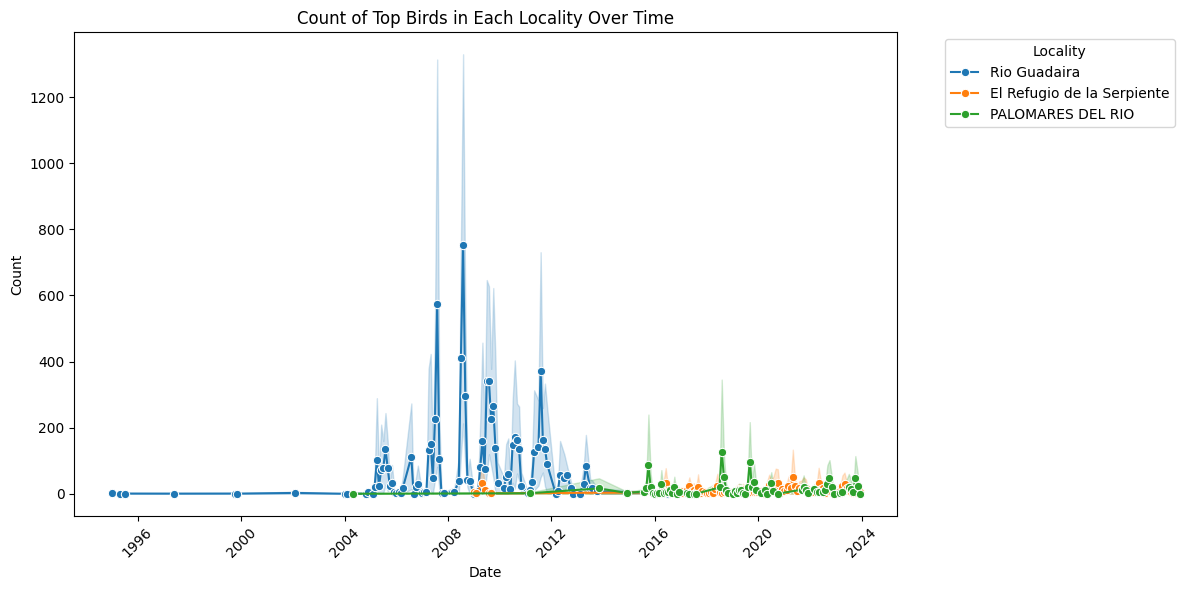

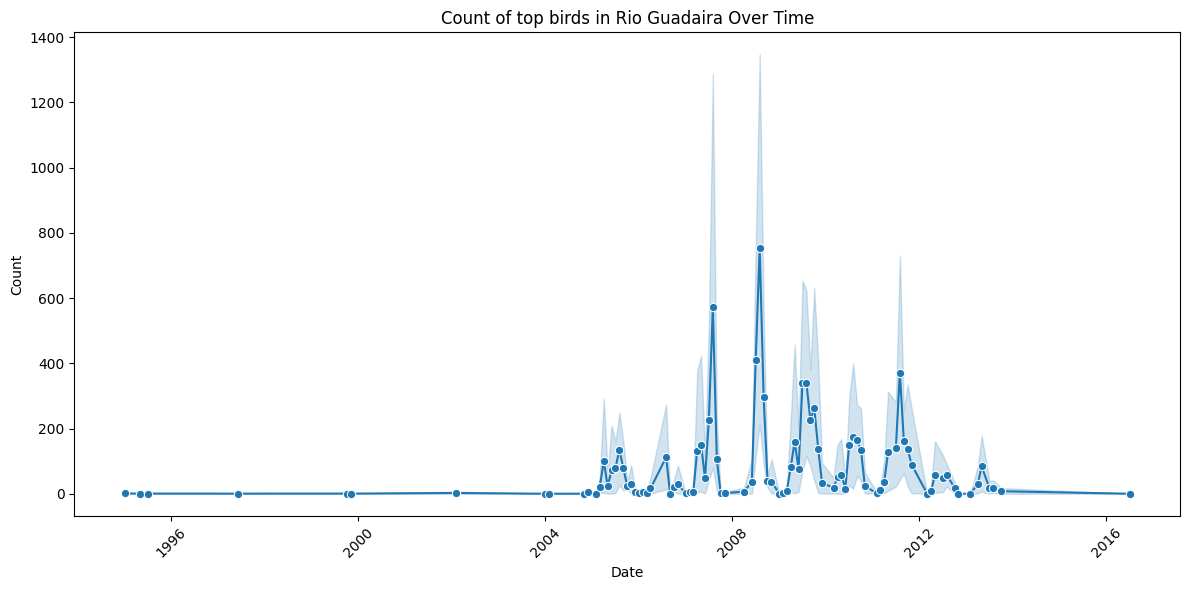

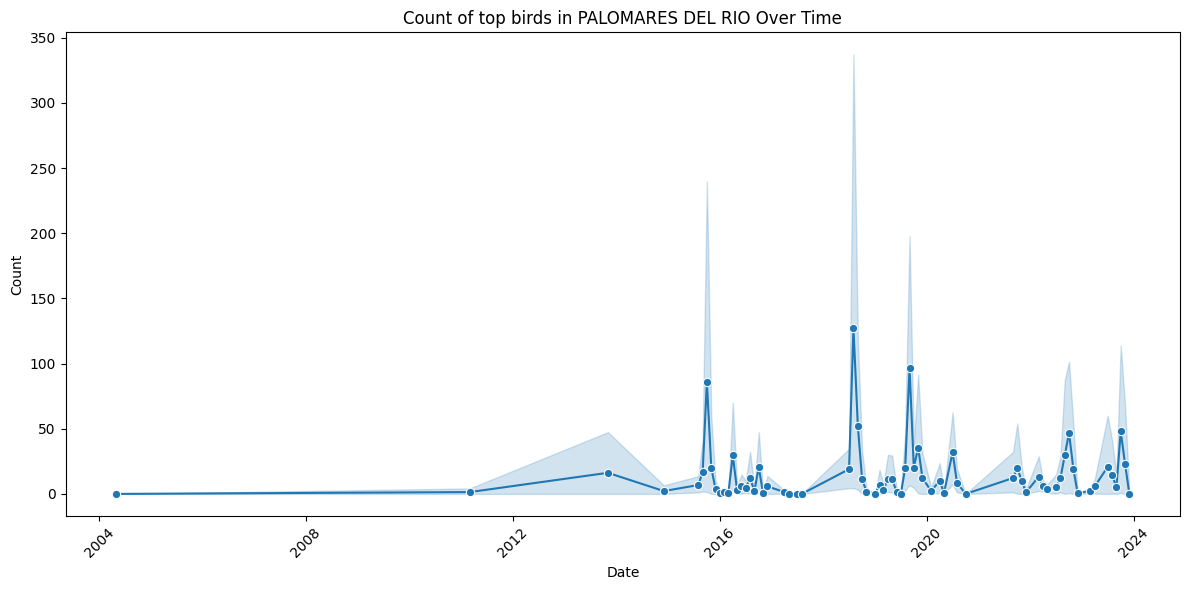

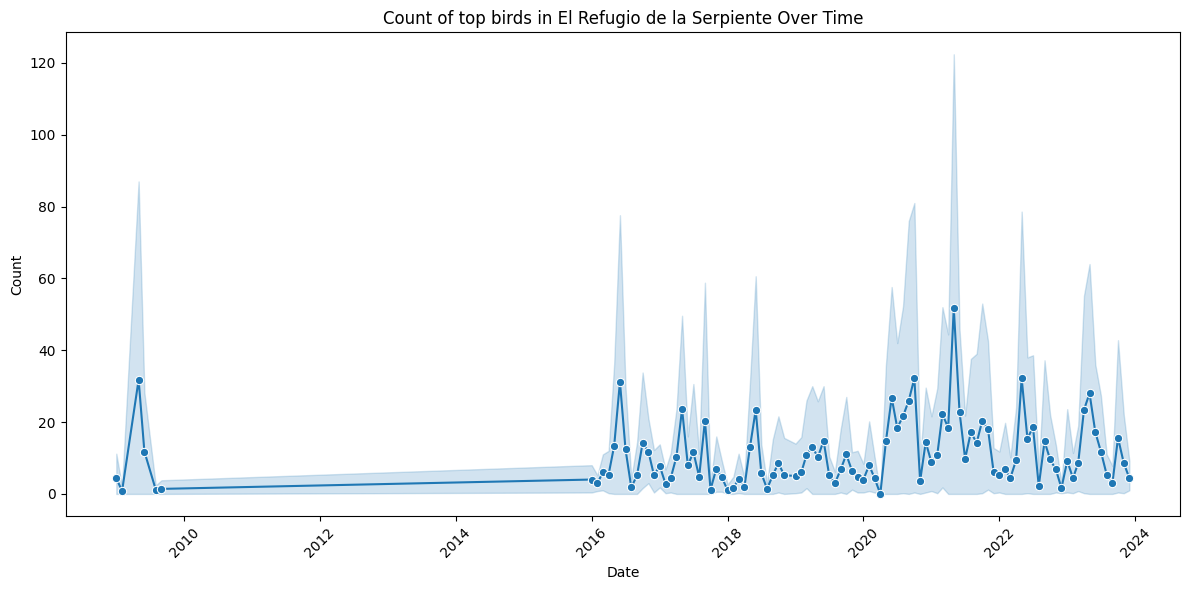

Locality with the most data: Rio Guadaira


In [6]:
# Show when the top 5 birds are caught in the top 5 localities to decide which ones to use for a time series

# Get the 5 most common localities
top_localities = localities.nlargest(3)

# List the names and counts of the top localities
grouped_month_df_top_loc = grouped_month_df[grouped_month_df['NombreLocalidad'].isin(top_localities.index)]
grouped_month_df_top_loc['date'] = pd.to_datetime(grouped_month_df_top_loc[['year', 'month']].assign(DAY=1))
top_birds = grouped_month_df_top_loc.groupby('NombreEspecie')['count'].sum().nlargest(5)
# top_birds = grouped_month_df_top_loc['NombreEspecie'].value_counts().nlargest(10)

# Filter data for the selected species
species_data = grouped_month_df_top_loc[grouped_month_df_top_loc['NombreEspecie'].isin(top_birds.index.tolist())]

# Plot the count in each location over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='count', hue='NombreLocalidad', data=species_data, marker='o')
plt.title(f'Count of Top Birds in Each Locality Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Locality', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

for cld in top_localities.index:
    chosen_locality_data = species_data[species_data['NombreLocalidad'] == cld]

    # Plot the count for the chosen locality
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='date', y='count', data=chosen_locality_data, marker='o')
    plt.title(f'Count of top birds in {cld} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

print(f"Locality with the most data: {top_localities.idxmax()}")
max_locality = top_localities.idxmax()

Again, to select which bird is the best candidate for the time series, we are not interested in the bird that was simply caught most frequently in these localities. We want a bird that is consistently being caught each year. The following visualization helps us with this selection.

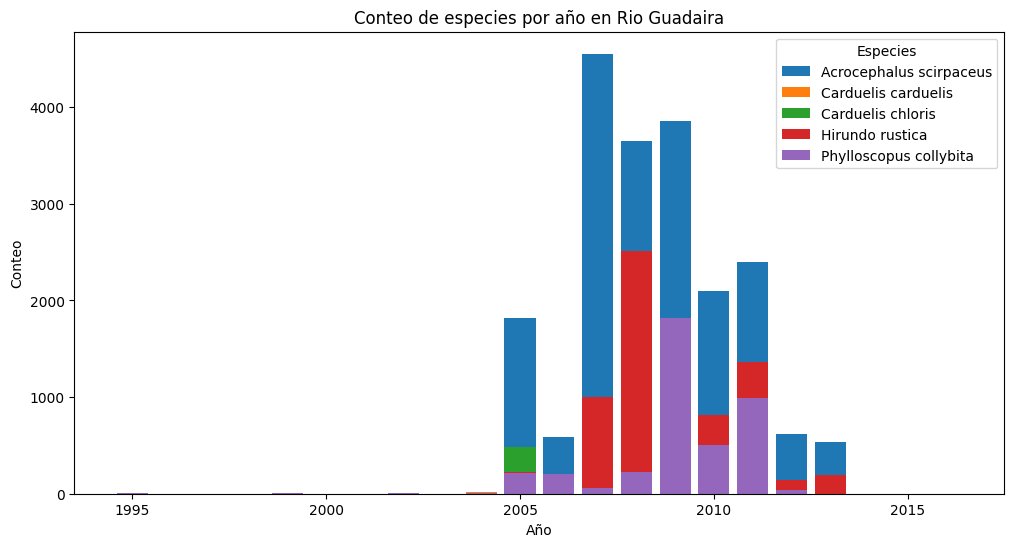

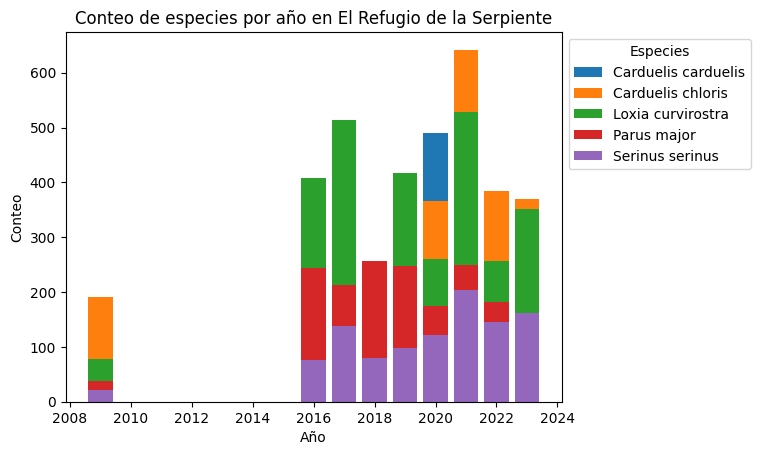

In [8]:
# Conteo de especies por año
plt.figure(figsize=(12, 6))
top_birds = grouped_year_df[grouped_year_df['NombreLocalidad']==loc1].groupby('NombreEspecie')['count'].sum().nlargest(5)
loc1Birds = grouped_year_df[(grouped_year_df['NombreLocalidad']==loc1) & (grouped_year_df['NombreEspecie'].isin(top_birds.index.tolist()))]
for species, data in loc1Birds.groupby('NombreEspecie'):
    plt.bar(data['year'], data['count'], label=species)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title(f"Conteo de especies por año en {loc1}")
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()

loc3= localities.index[2]
top_birds = grouped_year_df[grouped_year_df['NombreLocalidad']==loc3].groupby('NombreEspecie')['count'].sum().nlargest(5)
loc3Birds = grouped_year_df[(grouped_year_df['NombreLocalidad']==loc3) & (grouped_year_df['NombreEspecie'].isin(top_birds.index.tolist()))]
for species, data in loc3Birds.groupby('NombreEspecie'):
    plt.bar(data['year'], data['count'], label=species)
plt.xlabel('Año')
plt.ylabel('Conteo')
plt.title(f"Conteo de especies por año en {loc3}")
plt.legend(title='Especies', bbox_to_anchor=(1, 1))
plt.show()

Based on the distribution of data in these graphs, a time series will be created for Acrocephalus scirpaceus in Rio Guadaira and for Serinus serinus and parus major in El Refugio de la Serpiente.

## 4.Predicción series temporales

Debido a que las series temporales no pueden manejar predicciones espacio-temporales, seleccionamos una especie y una ubicación para modelar. Para seleccionar la ubicación, queremos asegurarnos de que tenga una buena cantidad de datos a lo largo de varios años. La siguiente visualización nos ayuda con esta decisión.

### 4.1. Optimización de parámetros

### 4.2. Definición del modelo
Crearemos un modelo para el mosquitero común localidad en la localidad Parque el alamillo. El conjunto de datos siguiente es lo que alimentaremos en nuestro modelo:

/var/folders/dx/9xjdddhn30jfw1p92r0hl5gh0000gn/T/ipykernel_35880/1905538456.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['date'] = pd.to_datetime(grouped_month_df_mean[['year', 'month']].assign(DAY=1))


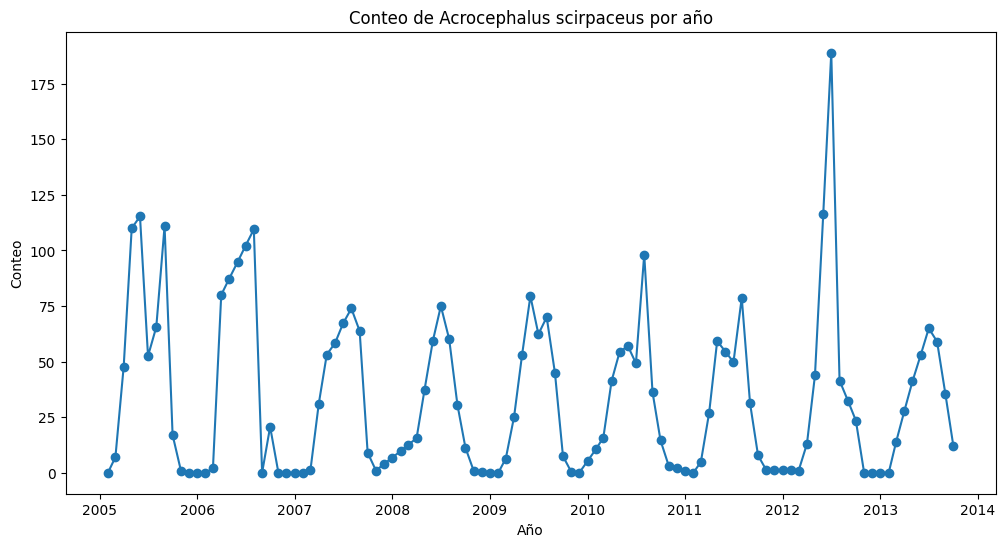

In [9]:
def defineSeries(especie, locality, desde, hasta):
    # Obtener la media promedio de anillado para esta especie en esta localidad
    grouped_month_df_mean = grouped_eventDate_df.groupby(['NombreEspecie', 'month', 'year', 'NombreLocalidad']).mean('count').reset_index()
    grouped_month_df_mean = grouped_month_df_mean.filter(items=['NombreEspecie', 'month', 'year', 'NombreLocalidad', 'count'])

    # Filtrar el DataFrame para la especie y localidad específicas
    df_filtrado = grouped_month_df_mean[(grouped_month_df_mean['NombreEspecie'] == especie) & (grouped_month_df_mean['NombreLocalidad'] == locality)]
    df_filtrado['date'] = pd.to_datetime(grouped_month_df_mean[['year', 'month']].assign(DAY=1))
    df_filtrado = df_filtrado.sort_values(by='date')
    df_filtrado = df_filtrado[(df_filtrado['date'] > desde) & (df_filtrado['date'] < hasta)]

    # Preparar los datos para el análisis de series temporales
    datos = df_filtrado.sort_values(by='date')
    datos = datos.drop(['NombreEspecie', 'NombreLocalidad'], axis=1)
    datos = datos.set_index('date')

    # Definir la frecuencia mensual
    start_date = datos.index.min()
    end_date = datos.index.max()
    new_dates = pd.date_range(start=start_date, end=end_date, freq='MS')
    new_datos = pd.DataFrame(index=new_dates)
    datos = new_datos.merge(datos, how='left', left_index=True, right_index=True)

    # Interpolar los valores faltantes por la media lineal
    datos['count'].interpolate(method='linear', limit_direction='both', inplace=True)
    return datos

def plotCountOverTime(datos, especie):
    # Visualizar la serie temporal
    plt.figure(figsize=(12, 6))
    plt.plot(datos.index, datos['count'], marker='o', label=especie)
    plt.xlabel('Año')
    plt.ylabel('Conteo')
    plt.title(f"Conteo de {especie} por año")
    plt.show()

# Especificar la especie y localidad
loc1_grouped_month_df = grouped_month_df[grouped_month_df['NombreLocalidad']==loc1]
top_birds = loc1_grouped_month_df.groupby('NombreEspecie')['count'].sum().nlargest(5)

especie = top_birds.index[0]
datos = defineSeries(especie, loc1, '2005-01-01', '2015-01-01')
plotCountOverTime(datos, especie)

### Apply Seasonal Decomposition to the Data

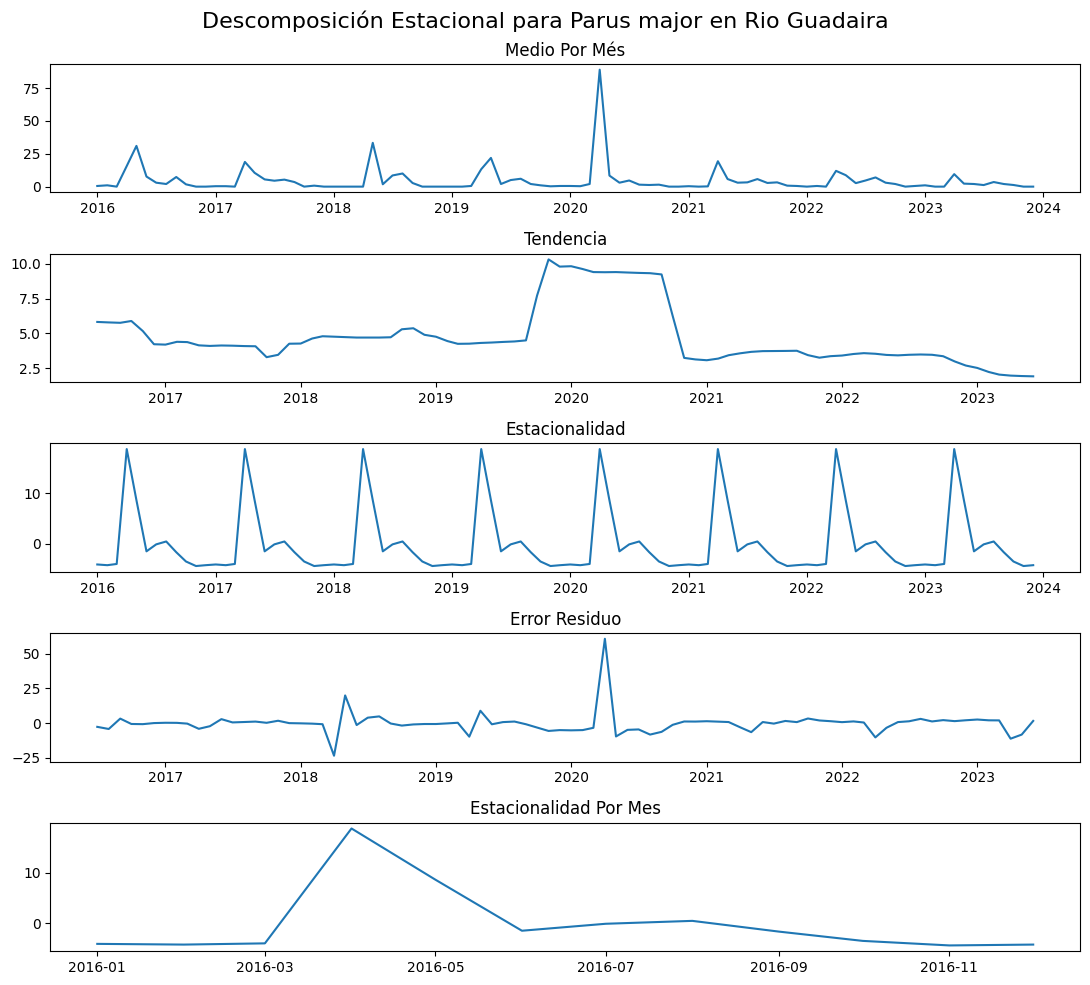

In [26]:
def plotSeasonalDecomp(data, especie, loc):
    # Perform seasonal decomposition
    result = seasonal_decompose(data['count'], model='additive', period=12)

    # Create a figure and subplots
    fig, axs = plt.subplots(5, 1, figsize=(11, 10))

    # Set the main title above all subplots
    fig.suptitle(f"Descomposición Estacional para {especie} en {loc}", fontsize=16)

    # Plot each component
    axs[0].plot(data['count'])
    axs[0].set_title(f"Medio Por Més")

    axs[1].plot(result.trend)
    axs[1].set_title(f"Tendencia")

    axs[2].plot(result.seasonal)
    axs[2].set_title(f"Estacionalidad")    

    axs[3].plot(result.resid)
    axs[3].set_title(f"Error Residuo")

    axs[4].plot(result.seasonal[0:12])
    axs[4].set_title(f"Estacionalidad Por Mes")
    plt.tight_layout()
    plt.show()

# Example usage
plotSeasonalDecomp(datos, especie, loc1)


### 4.3. Selección de Hyperparámetros
Utilizamos los gráficos de autocorrelación y autocorrelación parcial para determinar el intervalo de parámetros que debemos introducir en un GridSearch. Los picos en el PACF indican valores p potencialmente buenos (orden de autoregresión) y los picos en el ACF indican valores q potencialmente buenos (orden de media móvil). Sin embargo, debido a la limitación de los recursos informáticos, la búsqueda fue limitada.

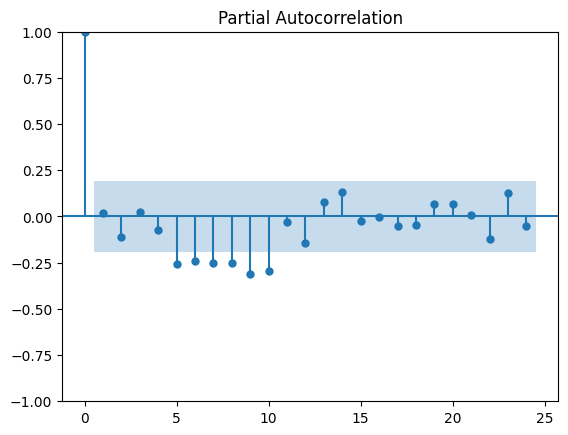

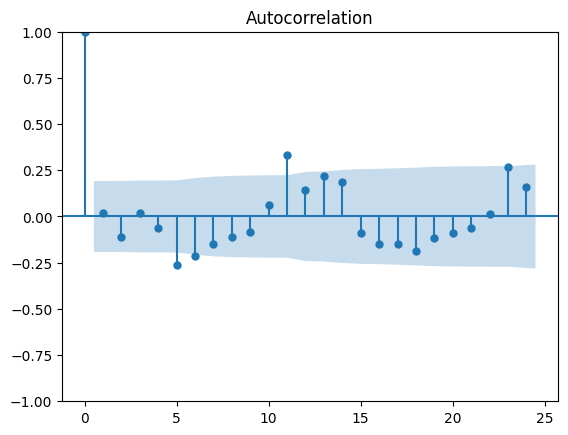

In [11]:
# With one order of differencing
diff = datos['count'].diff().dropna()
plot_pacf(diff, lags=24)
plot_acf(diff, lags=24)
plt.show()

In [16]:
%%capture
# optimizacion de parámetros
def gridSearch(p_values, d_values, q_values, P_values, D_values, Q_values, data):
    # Almacena los resultados y los criterios de evaluación
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None

    # Grid Search
    # Itera sobre todas las combinaciones posibles
    for p, d, q, P, D, Q in product(p_values, d_values, q_values, P_values, D_values, Q_values):
        try:
            # Ajusta el modelo SARIMA
            order = (p, d, q)
            seasonal_order = (P, D, Q, 12)  # La estacionalidad asumida es anual
            sarima_model = SARIMAX(data['count'], order=order, seasonal_order=seasonal_order)
            sarima_results = sarima_model.fit(disp=False)

            # Almacena el modelo si mejora el criterio de evaluación (menor AIC en este caso)
            if sarima_results.aic < best_aic:
                best_aic = sarima_results.aic
                best_order = order
                best_seasonal_order = seasonal_order

        except Exception as e:
            continue
    return best_order, best_seasonal_order, best_aic

p_values = [0, 1]
d_values = [1, 2]
q_values = [1, 6]
P_values = [0, 1]
D_values = [1]
Q_values = [1, 6]
best_order, best_seasonal_order, best_aic = gridSearch(p_values, d_values, q_values, P_values, D_values, Q_values, datos)

In [27]:
# Muestra los mejores parámetros encontrados
print(f"Best SARIMA Order: {best_order}")
print(f"Best SARIMA Seasonal Order: {best_seasonal_order}")

# Ajusta el modelo SARIMA con los mejores parámetros
best_sarima_model = SARIMAX(datos['count'], order=best_order, seasonal_order=best_seasonal_order)

Best SARIMA Order: (0, 1, 1)
Best SARIMA Seasonal Order: (0, 1, 1, 12)


### 4.4. Obtención de la serie temporal

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36142D+00    |proj g|=  2.58127D-02


 This problem is unconstrained.



At iterate    5    f=  3.25812D+00    |proj g|=  4.32394D-03

At iterate   10    f=  3.25568D+00    |proj g|=  9.37687D-04

At iterate   15    f=  3.25543D+00    |proj g|=  2.17944D-05

At iterate   20    f=  3.25541D+00    |proj g|=  2.97122D-05

At iterate   25    f=  3.25540D+00    |proj g|=  1.39988D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     30      1     0     0   1.226D-06   3.255D+00
  F =   3.2554039855630350     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


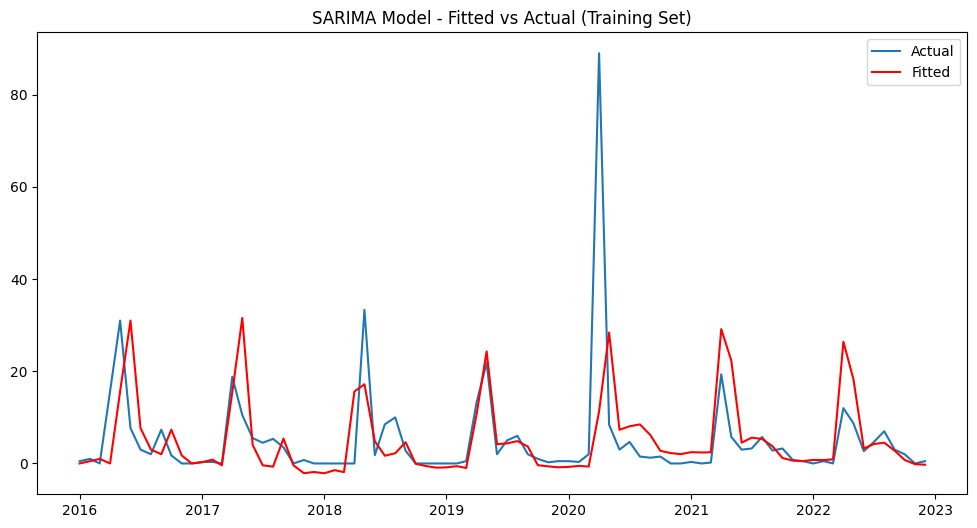

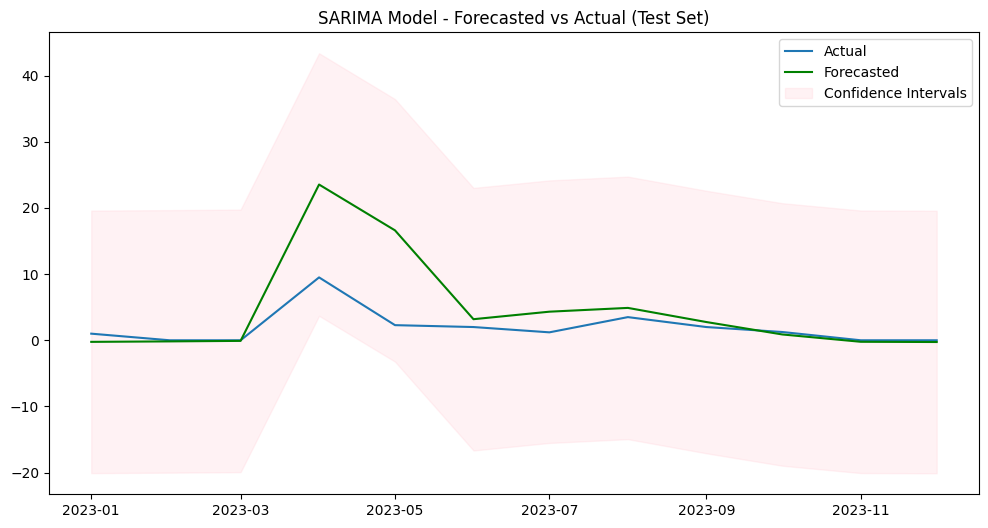

Mean Absolute Error: 3.10
Mean Squared Error: 34.78
Root Mean Squared Error: 5.90


In [29]:
# Definir el tamaño del conjunto de prueba
def showFinalPredictions(order, seasonal_order, data):
    test_size = 12  # Dos años de datos de prueba - 5% del dataset

    # Dividir los datos en conjuntos de entrenamiento y prueba
    train_data = data[:-test_size]
    test_data = data[-test_size:]

    # Crear y ajustar el modelo SARIMA en los datos de entrenamiento
    sarima_model = SARIMAX(train_data['count'], order=order, seasonal_order=seasonal_order)
    sarima_results = sarima_model.fit()

    # Graficar valores pronosticados vs reales para el conjunto de entrenamiento
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['count'], label='Actual')
    plt.plot(sarima_results.fittedvalues, label='Fitted', color='red')
    plt.title('SARIMA Model - Fitted vs Actual (Training Set)')
    plt.legend()
    plt.show()

    # Pronóstico en el conjunto de prueba
    forecast = sarima_results.get_forecast(steps=test_size)

    # Extracción de valores reales del conjunto de prueba
    actual_values = test_data['count']

    # Extracción de valores pronosticados y intervalos de confianza
    forecasted_values = forecast.predicted_mean
    ci_lower = forecast.conf_int()['lower count']
    ci_upper = forecast.conf_int()['upper count']

    # Cálculo de métricas de evaluación
    mae = mean_absolute_error(actual_values, forecasted_values)
    mse = mean_squared_error(actual_values, forecasted_values)
    rmse = np.sqrt(mse)

    # Visualización del pronóstico con intervalos de confianza
    plt.figure(figsize=(12, 6))
    plt.plot(actual_values, label='Actual')
    plt.plot(forecasted_values, label='Forecasted', color='green')
    plt.fill_between(actual_values.index, ci_lower, ci_upper, color='pink', alpha=0.2, label='Confidence Intervals')
    plt.title('SARIMA Model - Forecasted vs Actual (Test Set)')
    plt.legend()
    plt.show()

    # Métricas de evaluación
    print(f'Mean Absolute Error: {mae:.2f}')
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'Root Mean Squared Error: {rmse:.2f}')

showFinalPredictions(best_order, best_seasonal_order, datos)

### Conclusions for species #1 & Loc #1
TODO

/var/folders/dx/9xjdddhn30jfw1p92r0hl5gh0000gn/T/ipykernel_35880/1905538456.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['date'] = pd.to_datetime(grouped_month_df_mean[['year', 'month']].assign(DAY=1))


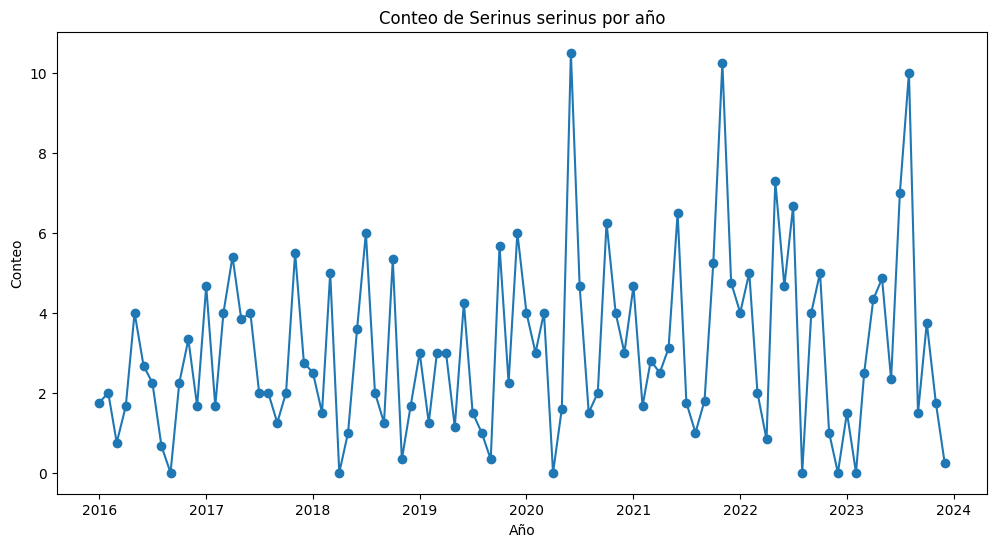

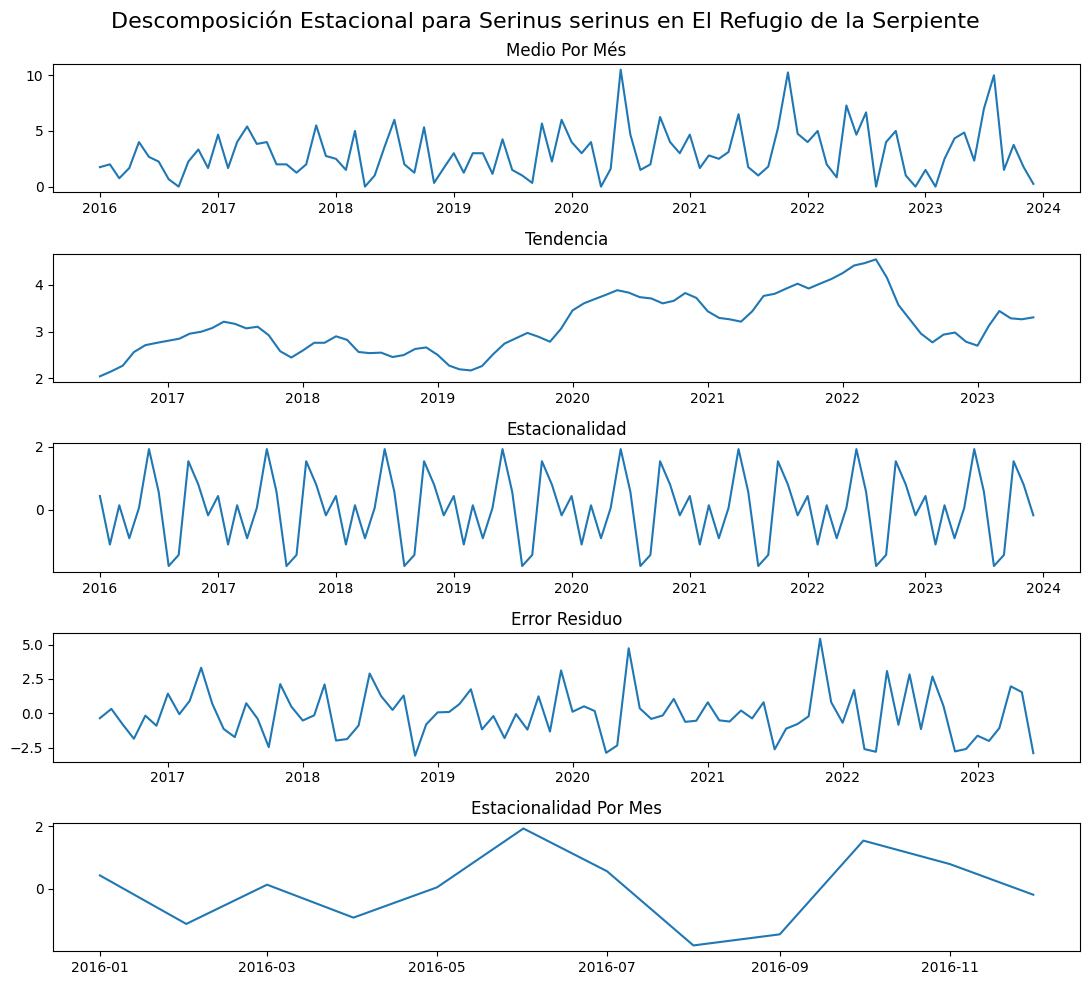

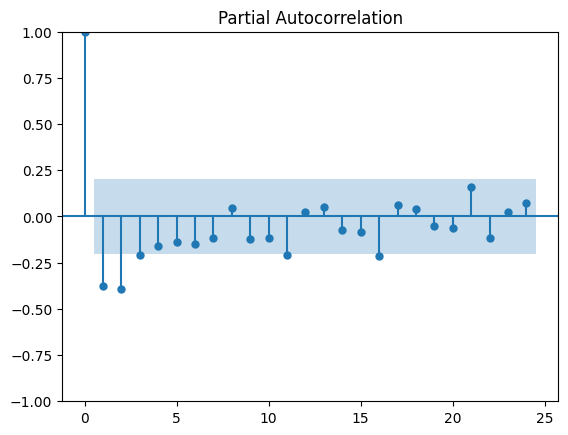

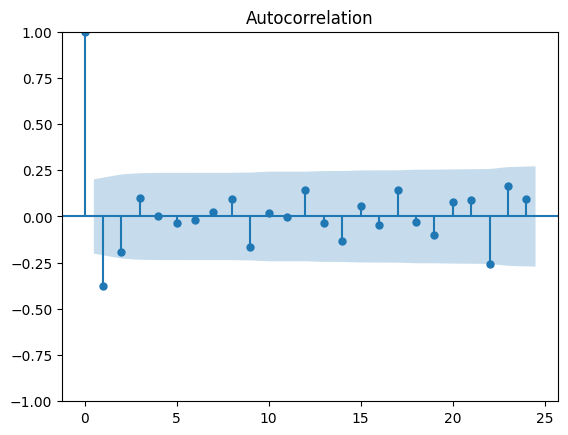

In [30]:
# Especificar la especie y localidad
loc_grouped_month_df = grouped_month_df[grouped_month_df['NombreLocalidad']==loc3]
top_birds = loc_grouped_month_df.groupby('NombreEspecie')['count'].sum().nlargest(5)
especie = "Serinus serinus"
datos = defineSeries(especie, loc3, '2015-01-01', '2024-01-01')
plotCountOverTime(datos, especie)

result = seasonal_decompose(datos['count'], model='additive', period=12)
plotSeasonalDecomp(datos, especie, loc3)

diff = datos['count'].diff().dropna()
plot_pacf(diff, lags=24)
plot_acf(diff, lags=24)
plt.show()

/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/daniellemckenney/Programming/erasmusCours

Best SARIMA Order: (0, 0, 0)
Best SARIMA Seasonal Order: (0, 1, 1, 12)
Best SARIMA AIC: 395.36506151330565
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00896D+00    |proj g|=  1.09963D-01

At iterate    5    f=  1.92736D+00    |proj g|=  9.69509D-04

At iterate   10    f=  1.92726D+00    |proj g|=  8.32747D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     11      1     0     0   8.327D-06   1.927D+00
  F =   1.9272574793379273     

CONVERGENCE: NORM_OF_PRO

 This problem is unconstrained.


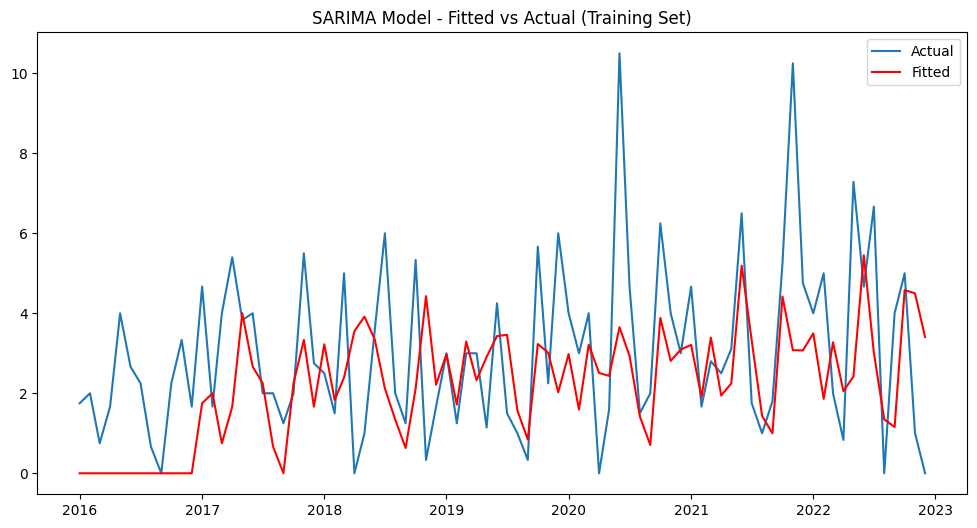

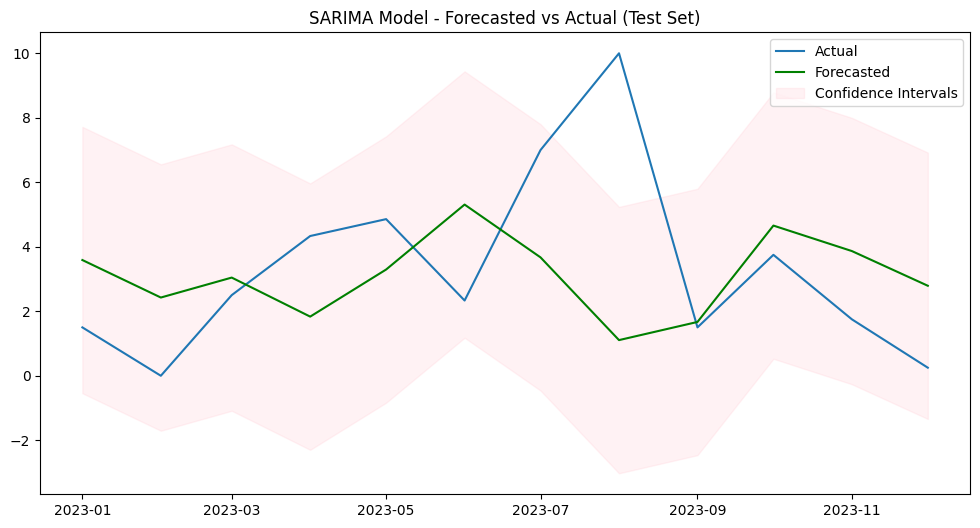

Mean Absolute Error: 2.50
Mean Squared Error: 10.84
Root Mean Squared Error: 3.29


In [32]:
p_values = [0, 2]
d_values = [0,1]
q_values = [0, 1]
P_values = [0, 2]
D_values = [1]
Q_values = [0, 1]
best_order, best_seasonal_order, best_aic = gridSearch(p_values, d_values, q_values, P_values, D_values, Q_values, datos)

print(f"Best SARIMA Order: {best_order}")
print(f"Best SARIMA Seasonal Order: {best_seasonal_order}")
print(f"Best SARIMA AIC: {best_aic}")

showFinalPredictions(best_order, best_seasonal_order, datos)

/var/folders/dx/9xjdddhn30jfw1p92r0hl5gh0000gn/T/ipykernel_35880/1905538456.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['date'] = pd.to_datetime(grouped_month_df_mean[['year', 'month']].assign(DAY=1))


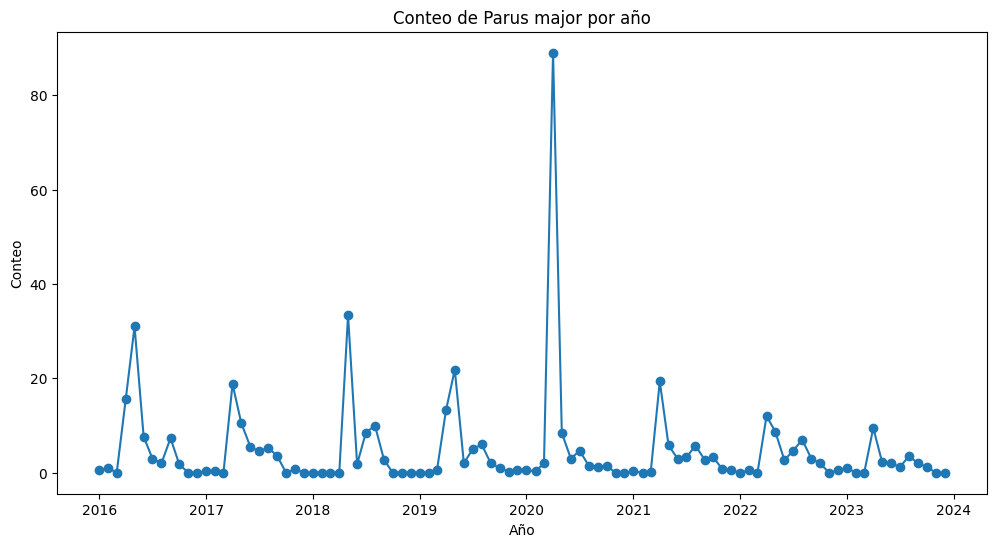

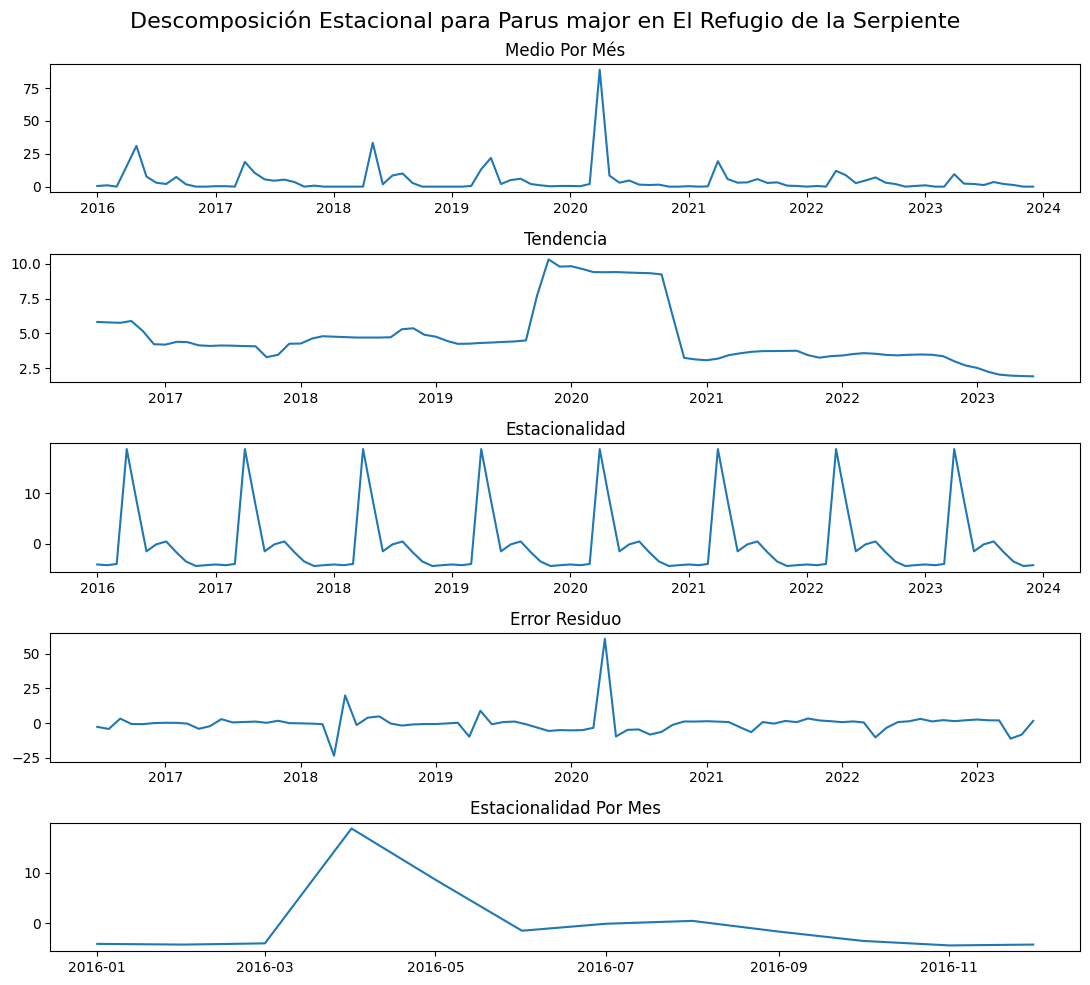

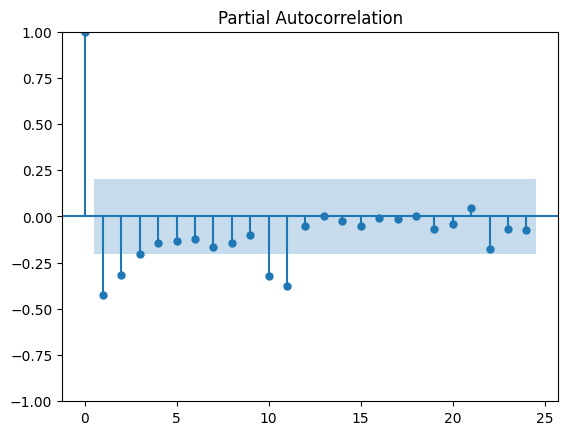

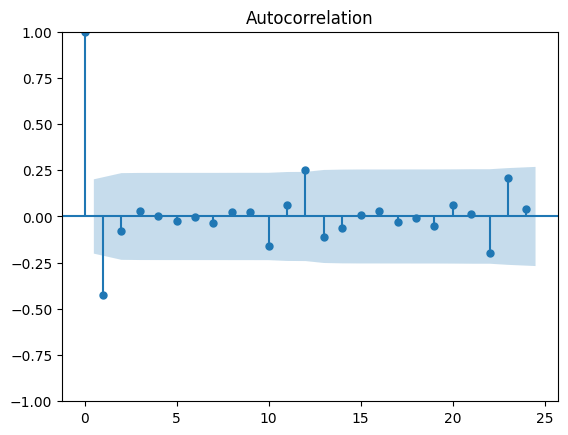

In [33]:
# Especificar la especie y localidad
loc_grouped_month_df = grouped_month_df[grouped_month_df['NombreLocalidad']==loc3]
top_birds = loc_grouped_month_df.groupby('NombreEspecie')['count'].sum().nlargest(5)
especie = "Parus major"
datos = defineSeries(especie, loc3, '2015-01-01', '2024-01-01')
plotCountOverTime(datos, especie)

result = seasonal_decompose(datos['count'], model='additive', period=12)
plotSeasonalDecomp(datos, especie, loc3)

diff = datos['count'].diff().dropna()
plot_pacf(diff, lags=24)
plot_acf(diff, lags=24)
plt.show()

/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final Project/proyecto_ds/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/daniellemckenney/Programming/erasmusCourses/DS/Final P

Best SARIMA Order: (0, 0, 0)
Best SARIMA Seasonal Order: (0, 1, 1, 12)
Best SARIMA AIC: 632.6921543469575
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36971D+00    |proj g|=  3.17153D-02

At iterate    5    f=  3.26329D+00    |proj g|=  9.10419D-03


 This problem is unconstrained.



At iterate   10    f=  3.25894D+00    |proj g|=  6.46865D-04

At iterate   15    f=  3.25857D+00    |proj g|=  1.78839D-04

At iterate   20    f=  3.25854D+00    |proj g|=  9.26801D-05

At iterate   25    f=  3.25853D+00    |proj g|=  2.01101D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     26     29      1     0     0   8.182D-06   3.259D+00
  F =   3.2585313057270744     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


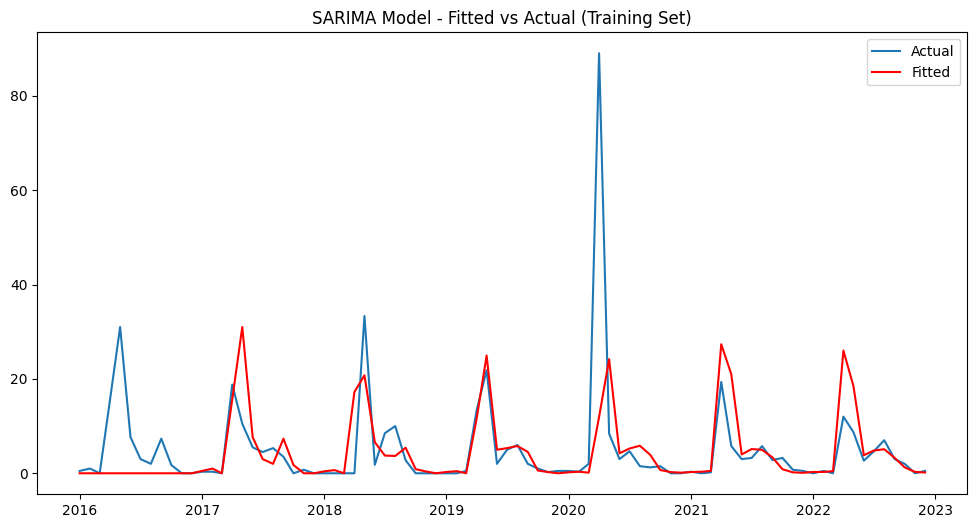

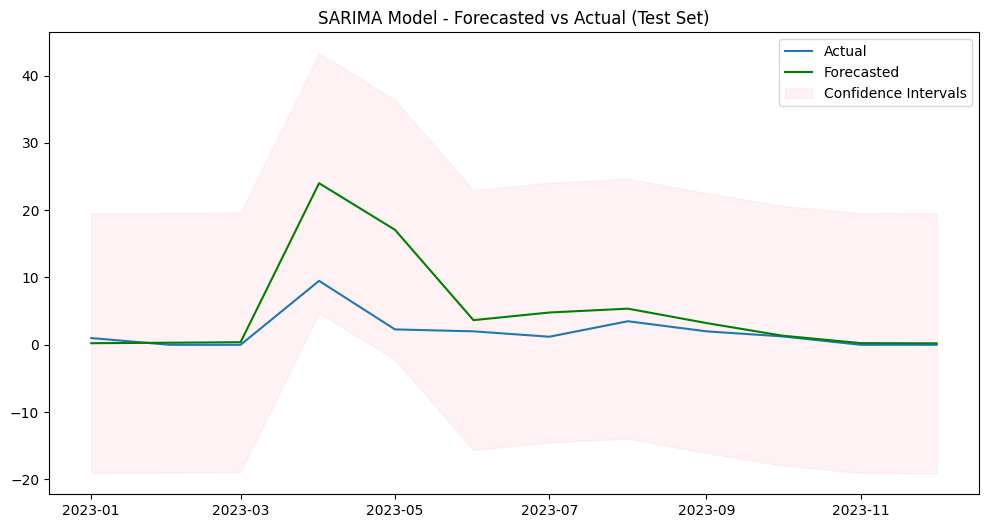

Mean Absolute Error: 3.31
Mean Squared Error: 37.59
Root Mean Squared Error: 6.13


In [34]:
p_values = [0, 1]
d_values = [0,1]
q_values = [0, 1]
P_values = [0, 1]
D_values = [1]
Q_values = [0, 1]
best_order, best_seasonal_order, best_aic = gridSearch(p_values, d_values, q_values, P_values, D_values, Q_values, datos)

print(f"Best SARIMA Order: {best_order}")
print(f"Best SARIMA Seasonal Order: {best_seasonal_order}")
print(f"Best SARIMA AIC: {best_aic}")

showFinalPredictions(best_order, best_seasonal_order, datos)